Тут ми спробуємо вектори для текстів ПІСЛЯ зменшення словника

In [73]:
import pandas as pd
import numpy as np
from requests_finder import load_request, contains_mention
import re
import matplotlib.pyplot as plt

# Load data

In [12]:
df_tags = pd.read_excel("home_appliances_with_tags.xlsx", index_col=0)
print(f"Loaded {df_tags.shape[0]} rows")

df_rus = pd.read_excel("home_appliances_rus_reduced.xlsx", index_col=0)
print(f"Loaded {df_rus.shape[0]} rows")

Loaded 6802 rows
Loaded 6802 rows


In [13]:
df_tags.head(1)

,title,text,source_type,source,date,home_appliances,MAIN_1: НЕРЕЛЕВАНТ,MAIN_1: Продаж нової техніки,MAIN_1: Продаж Б/У,MAIN_1: Ремонт/Поломки/Деталі,...,MAIN_2: Морозильна камера,MAIN_2: Духовка,MAIN_2: Варочні поверхні,MAIN_2: Витяжка,MAIN_2: Мікрохвильовка,MAIN_2: Кондиціонер,MAIN_2: Пилосос,MAIN_2: Бойлер,clean_text,lang
0,Инверторные кондиционеры | Купить в Москве по ...,<p>Инверторные кондиционеры | Купить в Москве ...,Социальные сети,facebook,2022-01-20 15:53:00,True,False,True,False,False,...,False,False,False,False,False,True,False,False,инверторные кондиционеры купить в москве по вы...,ru


In [14]:
df_rus.head(1)

,mention,clean_text,language,clipped_part_correct,translated_text,clean_rus,clean_rus_no_stopwords,index,lemmatized,lemmatized_with_pos,lemmatized_with_vectors_and_pos,reduced_with_pos,reduced_no_pos
0,Инверторные кондиционеры | Купить в Москве по ...,инверторные кондиционеры | купить в москве по ...,ru,NaN,инверторные кондиционеры | купить в москве по ...,инверторные кондиционеры купить в москве по вы...,инверторные кондиционеры купить москве выгодно...,0,инверторный кондиционер покупать москве выгодн...,инверторный_ADJ кондиционер_NOUN покупать_VERB...,кондиционер_NOUN покупать_VERB москве_NOUN выг...,кондиционер_NOUN купить_VERB москве_NOUN выгод...,кондиционер купить москве выгодный расценка ус...


In [15]:
lemmatized = {}

for index in df_rus.index:
    lemmatized[index] = df_rus.loc[index, "reduced_no_pos"].split(" ")

In [16]:
df_tags.drop(columns=['title', 'text', 'source_type', 'source', 
                      'date', 'home_appliances', 'clean_text', 'lang'], inplace=True)

In [17]:
all_tags = list(df_tags.columns)
tag2id = {tag:i for i, tag in enumerate(all_tags)}
id2tag = {i:tag for tag, i in tag2id.items()}

### Create vocabulary and replace tokens with ids

In [18]:
vocab = []
for tokens in lemmatized.values():
    for word in tokens:
        if word not in vocab:
            vocab.append(word)

print(len(vocab))

7113


In [19]:
word2ind = {}
ind2word = {}
n = 0
for word in vocab:
    word2ind[word] = n
    ind2word[n] = word
    n += 1

In [20]:
lemmatized_w_ids = {}
for key, tokens in lemmatized.items():
    new_tokens = []
    for word in tokens:
        new_tokens.append(word2ind[word])
    lemmatized_w_ids[key] = new_tokens

# Do LDA

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://iopscience.iop.org/article/10.1088/2632-072X/ab8784/pdf

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

Parameters of LDA

1. Alpha parameter is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
2. Beta parameter is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.


In [27]:
import gensim
from gensim.models import LdaMulticore as LDA
import gensim.corpora as corpora

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(lemmatized.values())

# Create Corpus
texts = list(lemmatized.values())

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 2), (3, 1), (4, 3), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 4), (13, 1), (14, 4), (15, 1), (16, 1), (17, 3), (18, 4), (19, 1), (20, 2), (21, 1), (22, 1), (23, 4), (24, 2), (25, 2), (26, 2), (27, 3), (28, 2), (29, 1)]


In [30]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = LDA(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics)

# Print the Keyword in the 10 topics
for topic in lda_model.print_topics():
    print(topic)
# print(lda_model.print_topics())
doc_lda = lda_model[corpus]

(0, '0.028*"машина" + 0.027*"стиральный" + 0.019*"расценка" + 0.013*"квартира" + 0.010*"определение" + 0.010*"холодильник" + 0.009*"город" + 0.009*"сантиметр" + 0.008*"комната" + 0.008*"неделя"')
(1, '0.039*"стиральный" + 0.039*"машина" + 0.020*"samsung" + 0.020*"lg" + 0.016*"расценка" + 0.015*"однако" + 0.015*"холодильник" + 0.014*"грть" + 0.014*"килограмм" + 0.010*"неделя"')
(2, '0.025*"кондиционер" + 0.020*"который" + 0.016*"холодильник" + 0.010*"воздух" + 0.009*"пылесос" + 0.009*"samsung" + 0.008*"воздушный" + 0.008*"температура" + 0.007*"новинка" + 0.007*"тип"')
(3, '0.014*"холодильник" + 0.012*"камера" + 0.012*"квартира" + 0.012*"samsung" + 0.011*"объемный" + 0.009*"шкаф" + 0.009*"расценка" + 0.009*"сантиметр" + 0.008*"неделя" + 0.008*"который"')
(4, '0.049*"машина" + 0.044*"стиральный" + 0.023*"грть" + 0.013*"однако" + 0.009*"который" + 0.008*"lg" + 0.008*"килограмм" + 0.007*"продать" + 0.007*"город" + 0.007*"пылесос"')
(5, '0.025*"машина" + 0.018*"холодильник" + 0.014*"расценка

lets use only NOUNs and VERBs

In [35]:
nouns_and_verbs = {}
n_empty = 0
for index, row in df_rus.iterrows():
    mention = row["reduced_with_pos"].split()
    new_mention = []
    
    for word in mention:
        pos = word.split("_")[-1]
        if pos not in ["NOUN", "VERB"]:
            continue
        else:
            new_mention.append(word)
    
    if len(new_mention) != 0:
        nouns_and_verbs[index] = new_mention
    else:
        n_empty += 1
#         nouns_and_verbs[index] = None
        

print(f"Number of menitons with no NOUNS and VERBS is {n_empty}")

Number of menitons with no NOUNS and VERBS is 2


Now lets do LDA for the new set of words

In [36]:
# Create Dictionary
id2word = corpora.Dictionary(nouns_and_verbs.values())

# Create Corpus
texts = list(nouns_and_verbs.values())

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 4), (8, 1), (9, 4), (10, 1), (11, 1), (12, 3), (13, 2), (14, 1), (15, 4), (16, 2), (17, 2), (18, 2), (19, 3), (20, 2), (21, 1), (22, 4)]


In [38]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = LDA(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics)

# Print the Keyword in the 10 topics
for topic in lda_model.print_topics():
    print(f"{topic[0] + 1} | {topic[1]}\n")

doc_lda = lda_model[corpus]

0 | 0.026*"кондиционер_NOUN" + 0.025*"машина_NOUN" + 0.015*"расценка_NOUN" + 0.014*"неделя_NOUN" + 0.013*"воздух_NOUN" + 0.012*"техника_NOUN" + 0.012*"мочь_VERB" + 0.011*"купить_VERB" + 0.011*"пылесос_NOUN" + 0.011*"холодильник_NOUN"

1 | 0.019*"квартира_NOUN" + 0.018*"расценка_NOUN" + 0.016*"комната_NOUN" + 0.012*"техника_NOUN" + 0.012*"холодильник_NOUN" + 0.011*"гостиная_NOUN" + 0.011*"ремонт_NOUN" + 0.011*"машина_NOUN" + 0.010*"кондиционер_NOUN" + 0.010*"определение_NOUN"

2 | 0.039*"машина_NOUN" + 0.025*"грть_NOUN" + 0.024*"килограмм_NOUN" + 0.012*"смотреть_VERB" + 0.012*"сантиметр_NOUN" + 0.011*"загрузка_NOUN" + 0.011*"расценка_NOUN" + 0.010*"магазин_NOUN" + 0.010*"стирка_NOUN" + 0.010*"машинка_NOUN"

3 | 0.037*"холодильник_NOUN" + 0.023*"неделя_NOUN" + 0.016*"расценка_NOUN" + 0.012*"скидка_NOUN" + 0.010*"техника_NOUN" + 0.009*"продать_VERB" + 0.008*"машина_NOUN" + 0.006*"управлять_NOUN" + 0.006*"продавать_VERB" + 0.006*"кондиционер_NOUN"

4 | 0.030*"расценка_NOUN" + 0.027*"машина

Lets leave only NOUNS

In [50]:
nouns = {}
n_empty = 0
for index, row in df_rus.iterrows():
    mention = row["reduced_with_pos"].split()
    new_mention = []
    
    for word in mention:
        pos = word.split("_")[-1]
        if pos not in ["NOUN"]:
            continue
        else:
            new_mention.append(word)
    
    if len(new_mention) != 0:
        nouns[index] = new_mention
    else:
        n_empty += 1
#         nouns_and_verbs[index] = None
        

print(f"Number of menitons with no NOUNS and VERBS is {n_empty}")

Number of menitons with no NOUNS and VERBS is 4


Now lets do LDA for the new set of words

In [52]:
# Create Dictionary
id2word = corpora.Dictionary(nouns.values())

# Create Corpus
texts = list(nouns.values())

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 4), (6, 1), (7, 1), (8, 1), (9, 3), (10, 2), (11, 1), (12, 4), (13, 2), (14, 2), (15, 1), (16, 4)]


In [56]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = LDA(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics,
                iterations=200,
                alpha=0.99)

# Print the Keyword in the 10 topics
for topic in lda_model.print_topics():
    print(f"{topic[0] + 1} | {topic[1]}\n")

doc_lda = lda_model[corpus]

1 | 0.035*"расценка_NOUN" + 0.032*"машина_NOUN" + 0.024*"холодильник_NOUN" + 0.017*"неделя_NOUN" + 0.016*"грть_NOUN" + 0.015*"пылесос_NOUN" + 0.013*"квартира_NOUN" + 0.011*"килограмм_NOUN" + 0.011*"сантиметр_NOUN" + 0.010*"определение_NOUN"

2 | 0.048*"машина_NOUN" + 0.030*"холодильник_NOUN" + 0.026*"расценка_NOUN" + 0.019*"грть_NOUN" + 0.018*"квартира_NOUN" + 0.012*"техника_NOUN" + 0.012*"ремонт_NOUN" + 0.011*"килограмм_NOUN" + 0.011*"кондиционер_NOUN" + 0.011*"определение_NOUN"

3 | 0.040*"машина_NOUN" + 0.036*"холодильник_NOUN" + 0.021*"расценка_NOUN" + 0.013*"ремонт_NOUN" + 0.013*"килограмм_NOUN" + 0.013*"неделя_NOUN" + 0.012*"квартира_NOUN" + 0.011*"грть_NOUN" + 0.011*"сантиметр_NOUN" + 0.010*"кондиционер_NOUN"

4 | 0.042*"машина_NOUN" + 0.032*"холодильник_NOUN" + 0.023*"расценка_NOUN" + 0.022*"неделя_NOUN" + 0.015*"грть_NOUN" + 0.013*"килограмм_NOUN" + 0.011*"ремонт_NOUN" + 0.011*"квартира_NOUN" + 0.011*"пылесос_NOUN" + 0.011*"плита_NOUN"

5 | 0.026*"холодильник_NOUN" + 0.024*"ра

Окей, LDA дав сумнівний результат, не показавши якогось приросту в точності

# Doc2vec

In [57]:
import pickle
import os
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

In [68]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument

all_content_train = []
i = 0
old2new_index = {}
new2old_index = {}
for index, text in lemmatized.items():
    old2new_index[index] = i
    new2old_index[i] = index
    all_content_train.append(LabeledSentence1(text, [i]))
    i += 1

In [71]:
%%time

d2v_model = Doc2Vec(all_content_train, vector_size=3, window=10, 
                    workers=7, dm=1, alpha=0.025, epochs=100, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, 
                epochs=100, start_alpha=0.002, end_alpha=-0.016)

Wall time: 1min 26s


In [75]:
Z = d2v_model.dv.vectors

In [77]:
%matplotlib notebook

<IPython.core.display.Javascript object>


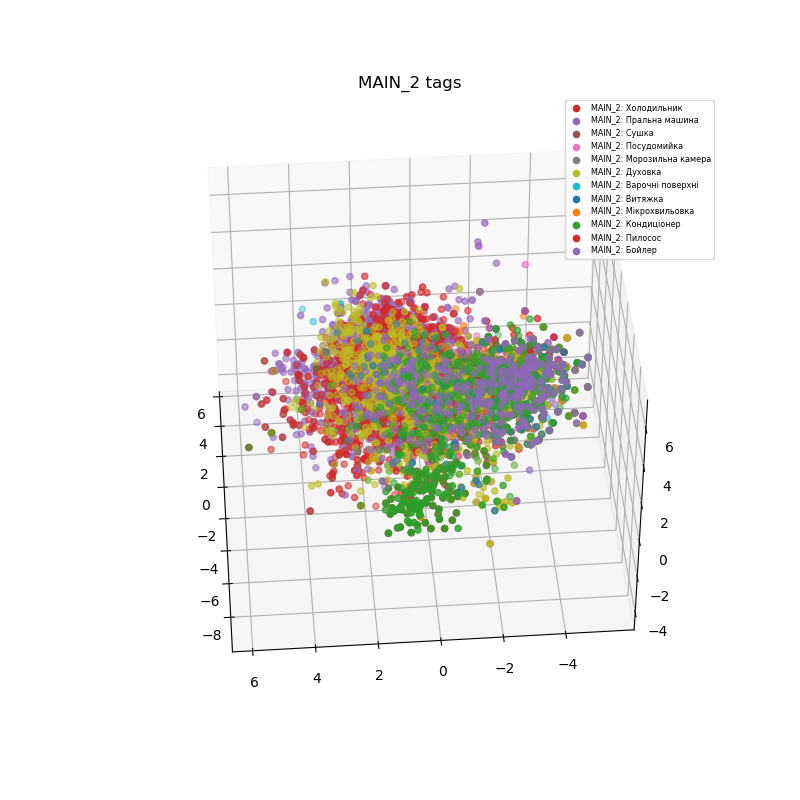

In [78]:
dims = (0, 1, 2)
# must be MAIN_1 or MAIN_2
tag_type = "MAIN_2"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for tag_name in df_tags.columns:
    if tag_type not in tag_name:
        continue
    
    indexes_old = df_tags[df_tags[tag_name]].index
    indexes_new = [old2new_index[i] for i in indexes_old]
    
    Z_temp = Z[indexes_new]
    ax.scatter(Z_temp[:, dims[0]], Z_temp[:, dims[1]], Z_temp[:, dims[2]], 
               c=f"C{tag2id[tag_name]}", label=tag_name)

plt.title('MAIN_2 tags')
plt.legend(loc="best", fontsize="xx-small")
plt.show()

<IPython.core.display.Javascript object>


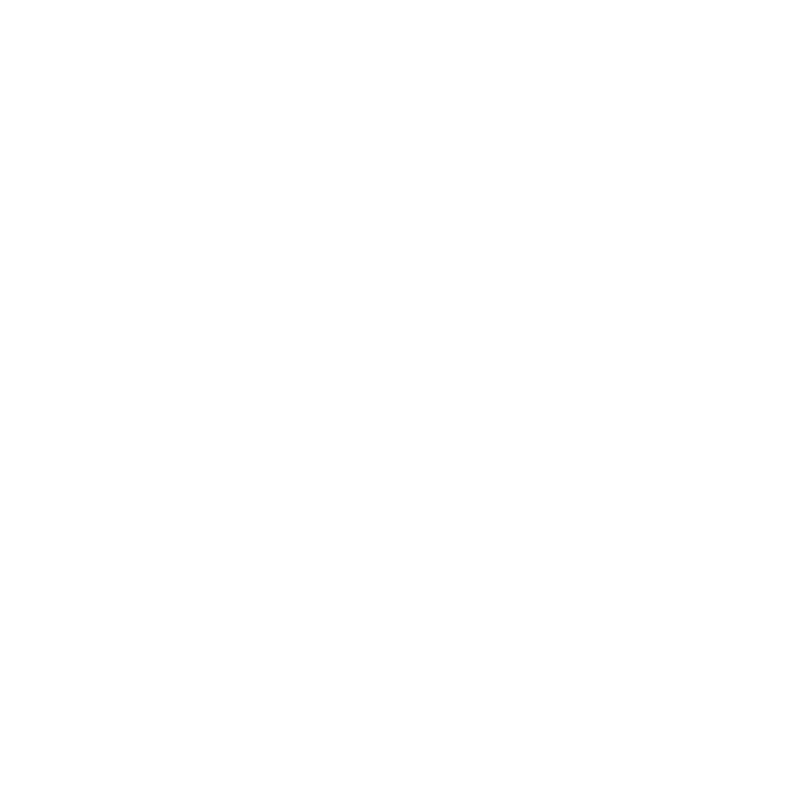

Wall time: 8min 10s


In [80]:
%%time

d2v_model = Doc2Vec(all_content_train, vector_size=100, window=10, 
                    workers=7, dm=1, alpha=0.025, epochs=100, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, 
                epochs=1000)

Z = PCA(n_components=3).fit_transform(d2v_model.dv.vectors)

<IPython.core.display.Javascript object>


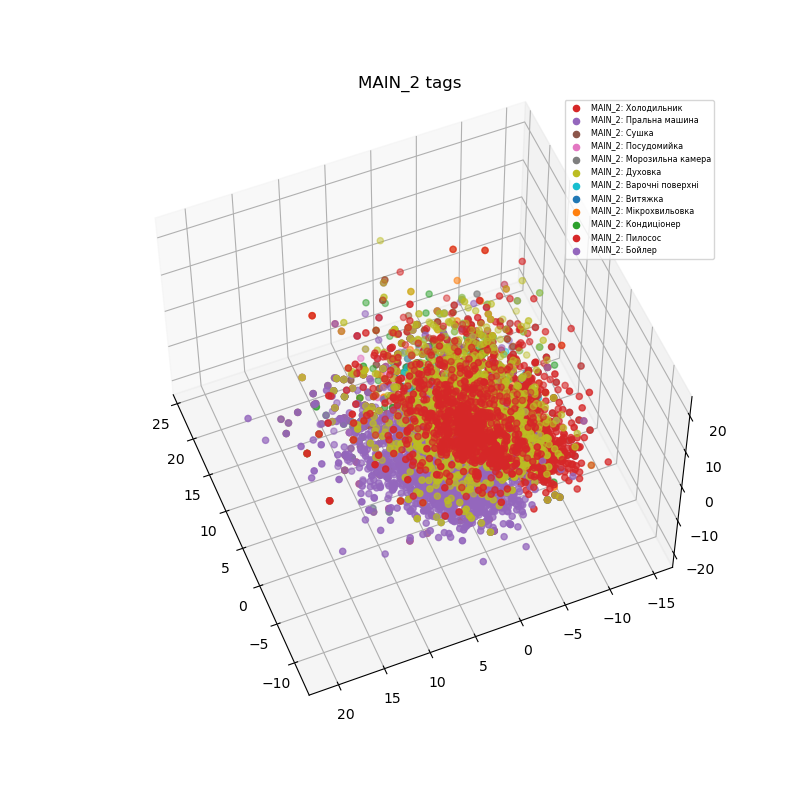

In [81]:
dims = (0, 1, 2)
# must be MAIN_1 or MAIN_2
tag_type = "MAIN_2"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for tag_name in df_tags.columns:
    if tag_type not in tag_name:
        continue
    
    indexes_old = df_tags[df_tags[tag_name]].index
    indexes_new = [old2new_index[i] for i in indexes_old]
    
    Z_temp = Z[indexes_new]
    ax.scatter(Z_temp[:, dims[0]], Z_temp[:, dims[1]], Z_temp[:, dims[2]], 
               c=f"C{tag2id[tag_name]}", label=tag_name)

plt.title('MAIN_2 tags')
plt.legend(loc="best", fontsize="xx-small")
plt.show()

<IPython.core.display.Javascript object>


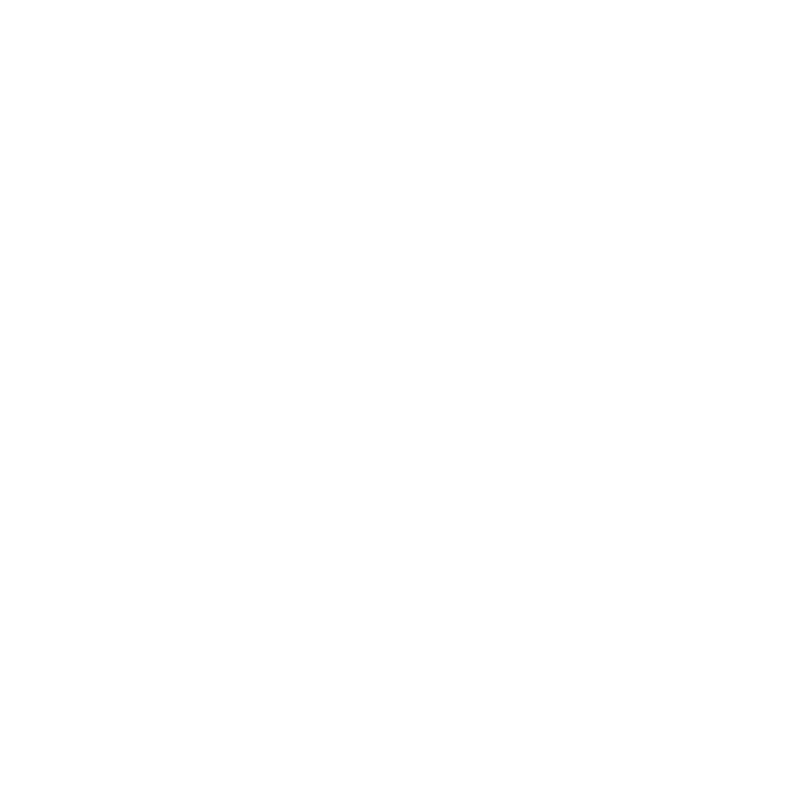

Wall time: 8min 10s


In [80]:
%%time

d2v_model = Doc2Vec(all_content_train, vector_size=100, window=10, 
                    workers=7, dm=1, alpha=0.025, epochs=100, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, 
                epochs=1000)

Z = PCA(n_components=3).fit_transform(d2v_model.dv.vectors)

<IPython.core.display.Javascript object>


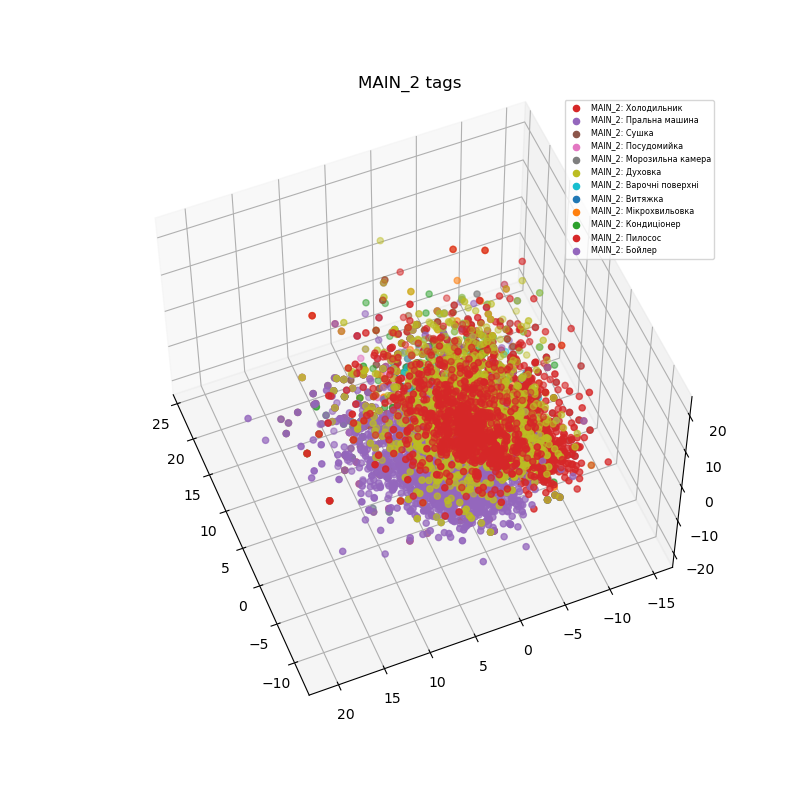

In [81]:
dims = (0, 1, 2)
# must be MAIN_1 or MAIN_2
tag_type = "MAIN_2"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for tag_name in df_tags.columns:
    if tag_type not in tag_name:
        continue
    
    indexes_old = df_tags[df_tags[tag_name]].index
    indexes_new = [old2new_index[i] for i in indexes_old]
    
    Z_temp = Z[indexes_new]
    ax.scatter(Z_temp[:, dims[0]], Z_temp[:, dims[1]], Z_temp[:, dims[2]], 
               c=f"C{tag2id[tag_name]}", label=tag_name)

plt.title('MAIN_2 tags')
plt.legend(loc="best", fontsize="xx-small")
plt.show()

In [63]:
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100)
X = kmeans_model.fit(d2v_model.dv.vectors)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=3).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)

<ipython-input-63-cc26ce19c314>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)


AttributeError: 'KeyedVectors' object has no attribute 'doctag_syn0'

In [ ]:
import matplotlib.pyplot as plt

plt.figure
label1 = [“#FFFF00”, “#008000”, “#0000FF”, “#800080”]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker=’^’, s=150, c=’#000000')
plt.show()